In [1]:
from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.statistics import A_mat_calc, twiss_calc, normalized_particle_coordinate
import numpy as np


import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (4,4)

# Simple Normalized Coordinates in ParticleGroup

1D normalized coordinates originate from the normal form decomposition, where the transfer matrix that propagates phase space coordinates $(x, p)$ is decomposed as

$M = A \cdot R(\theta) \cdot A^{-1}$

And the matrix $A$ can be parameterized as

A = $\begin{pmatrix}\sqrt{\beta} & 0\\-\alpha/\sqrt{\beta} & 1/\sqrt{\beta}\end{pmatrix}$


In [2]:
?A_mat_calc

Signature: A_mat_calc(beta, alpha, inverse=False)
Docstring:
Returns the 1D normal form matrix from twiss parameters beta and alpha

    A =   sqrt(beta)         0 
         -alpha/sqrt(beta)   1/sqrt(beta) 

If inverse, the inverse will be returned:

    A^-1 =  1/sqrt(beta)     0 
            alpha/sqrt(beta) sqrt(beta)     

This corresponds to the linear normal form decomposition:

    M = A . Rot(theta) . A^-1

with a clockwise rotation matrix:

    Rot(theta) =  cos(theta) sin(theta)
                 -sin(theta) cos(theta)

In the Bmad manual, G_q (Bmad) = A (here) in the Linear Optics chapter.

A^-1 can be used to form normalized coordinates: 
    x_bar, px_bar   = A^-1 . (x, px)
File:      ~/Code/GitHub/openPMD-beamphysics/pmd_beamphysics/statistics.py
Type:      function


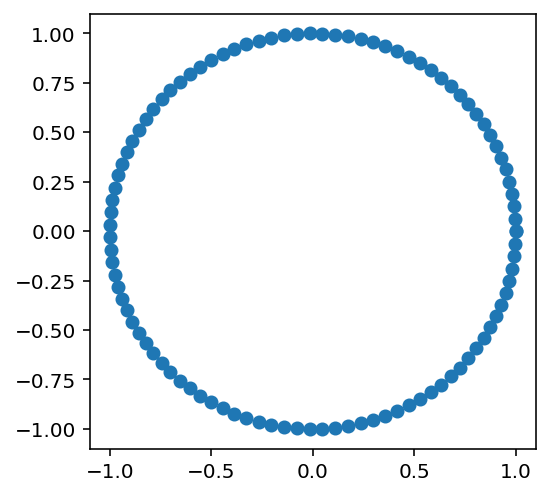

In [3]:
# Make phase space circle. This will represent some normalized coordinates

theta = np.linspace(0, np.pi*2, 100)
zvec0 = np.array([np.cos(theta), np.sin(theta)])
plt.scatter(*zvec0)

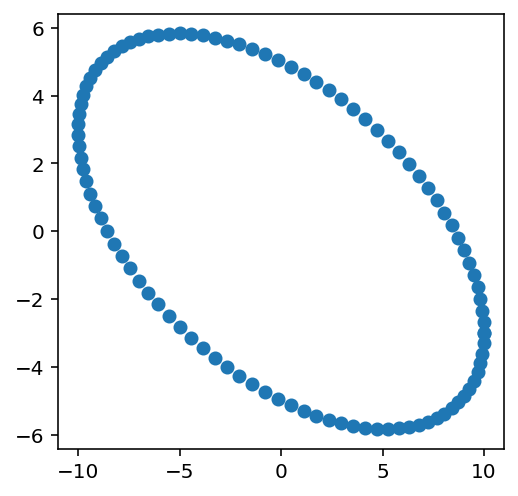

In [4]:
# Make a 'beam' in 'lab coordinates'
MYMAT = np.array([[10, 0],[-3, 5]])
zvec = np.matmul(MYMAT , zvec0)
plt.scatter(*zvec)

With a beam, $\alpha$ and $\beta$ can be determined from moments of the covariance matrix.

In [5]:
?twiss_calc

Signature: twiss_calc(sigma_mat2)
Docstring:
Calculate Twiss parameters from the 2D sigma matrix (covariance matrix):
sigma_mat = <x,x>   <x, p>
            <p, x>  <p, p>

This is a simple calculation. Makes no assumptions about units. 

beta  = -<x, p>/emit
beta  = <x, x>/emit
gamma = <p, p>/emit
emit = det(sigma_mat)
File:      ~/Code/GitHub/openPMD-beamphysics/pmd_beamphysics/statistics.py
Type:      function


In [6]:
# Calculate a sigma matrix, get the determinant
sigma_mat2 = np.cov(*zvec)
np.linalg.det(sigma_mat2)

637.5000000000003

In [7]:
# Get some twiss
twiss = twiss_calc(sigma_mat2)
twiss

{'alpha': 0.6059702963017244,
 'beta': 2.0199009876724157,
 'gamma': 0.6768648603788545,
 'emit': 25.248762345905202}

In [8]:
# Analyzing matrices
A = A_mat_calc(twiss['beta'], twiss['alpha'])
A_inv = A_mat_calc(twiss['beta'], twiss['alpha'], inverse=True)

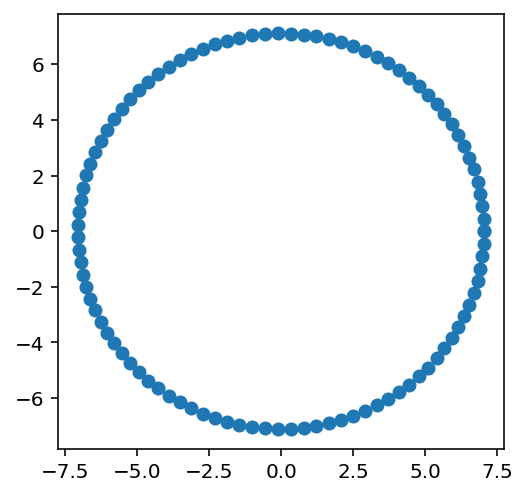

In [9]:
# A_inv turns this back into a circle. 
zvec2 = np.matmul(A_inv, zvec)
plt.scatter(*zvec2)

# Twiss parameters

Effective Twiss parameters can be calculated from the second order moments of the particles.


In [10]:
# This does not change the phase space area
twiss_calc(np.cov(*zvec2))

{'alpha': 3.1597888853181104e-16,
 'beta': 1.0,
 'gamma': 1.0000000000000002,
 'emit': 25.24876234590519}

In [11]:
# Reset plot
matplotlib.rcParams['figure.figsize'] = (13,8)

# x_bar, px_bar, Jx, etc.

These are essentially action-angle coordinates, calculated by using the an analyzing twiss dict

In [12]:
?normalized_particle_coordinate

Signature:
normalized_particle_coordinate(
    particle_group,
    key,
    twiss=None,
    mass_normalize=True,
)
Docstring:
Returns a single normalized coordinate array from a ParticleGroup

Position or momentum is determined by the key. 
If the key starts with 'p', it is a momentum, else it is a position,
and the

Intended use is for key to be one of:
    x, px, y py
    
and the corresponding normalized coordinates are named with suffix _bar, i.e.:
    x_bar, px_bar, y_bar, py_bar

If mass_normalize (default=True), the momentum will be divided by the mass, so that the units are sqrt(m).

These are related to action-angle coordinates
    J: amplitude
    phi: phase
    
    x_bar =  sqrt(2 J) cos(phi)
    px_bar = sqrt(2 J) sin(phi)
    
So therefore:
    J = (x_bar^2 + px_bar^2)/2
    phi = arctan(px_bar/x_bar)
and:        
    <J> = norm_emit_x
 
 Note that the center may need to be subtracted in this case.
 
File:      ~/Code/GitHub/openPMD-beamphysics/pmd_beamphysics/statistics.

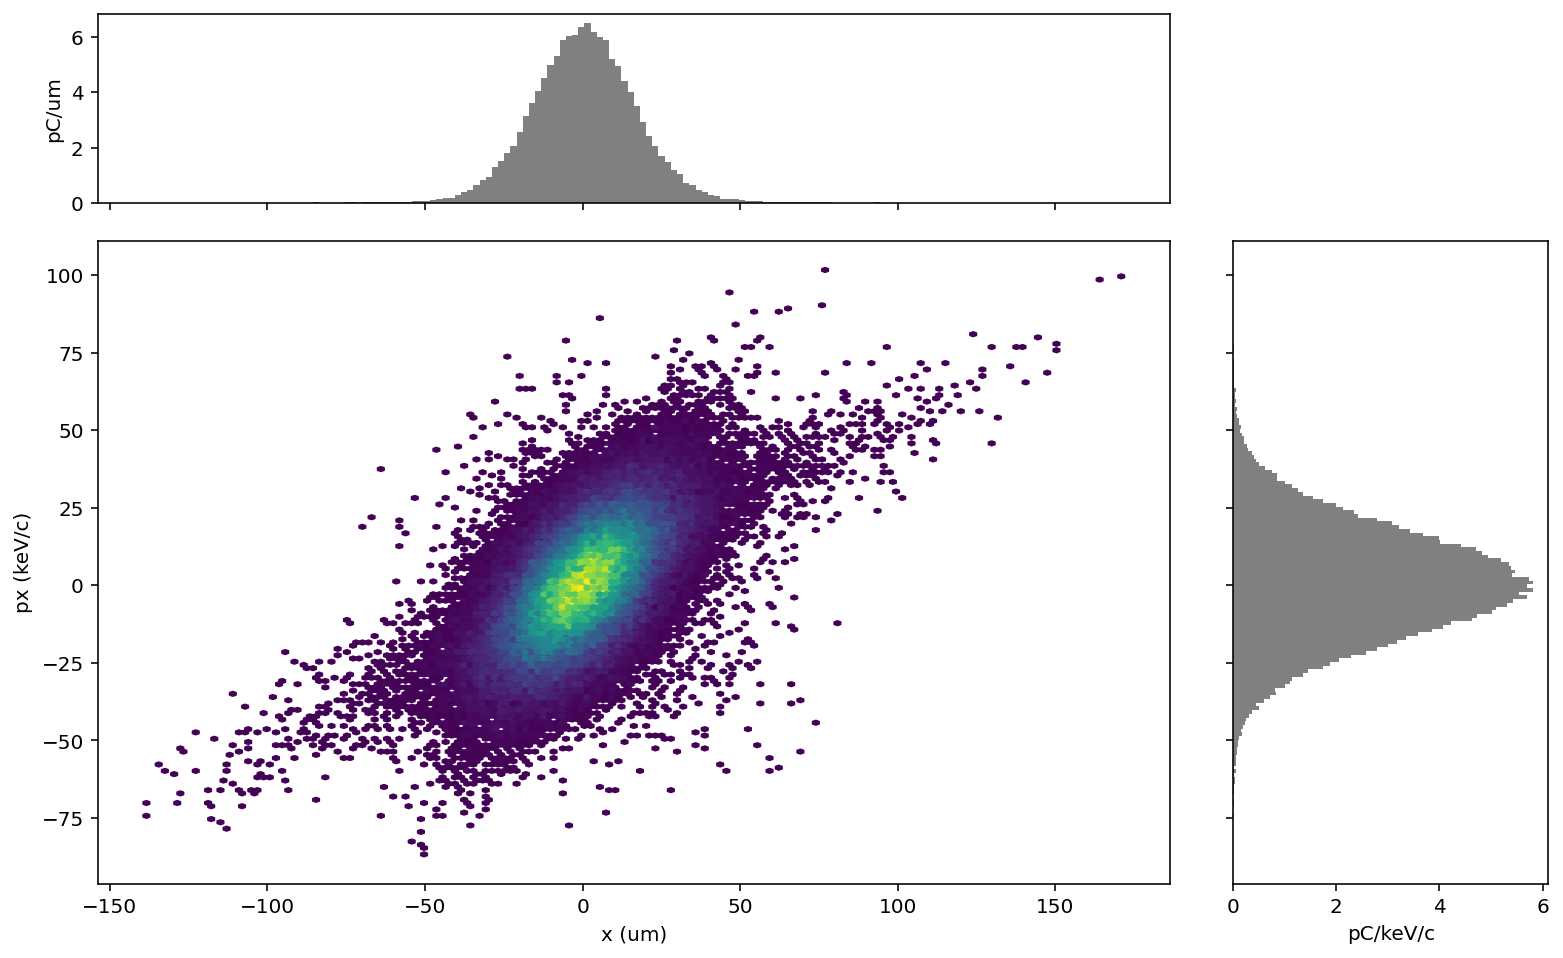

In [13]:
# Get some example particles
P = ParticleGroup('data/bmad_particles2.h5')

# This is a typical transverse phase space plot
P.plot('x', 'px')

In [14]:
# If no twiss is given, then the analyzing matrix is computed from the beam itself.
normalized_particle_coordinate(P, 'x', twiss=None)

array([-4.83384095e-04,  9.99855846e-04,  7.35820860e-05, ...,
       -7.48265408e-05,  4.77803205e-05, -4.18053319e-04])

In [15]:
# This is equivelent
normalized_particle_coordinate(P, 'x', twiss=twiss_calc(P.cov('x', 'px')), mass_normalize=False)/np.sqrt(P.mass)

array([-4.83384095e-04,  9.99855846e-04,  7.35820860e-05, ...,
       -7.48265408e-05,  4.77803205e-05, -4.18053319e-04])

In [16]:
# And is given as a property:
P.x_bar

array([-4.83384095e-04,  9.99855846e-04,  7.35820860e-05, ...,
       -7.48265408e-05,  4.77803205e-05, -4.18053319e-04])

In [17]:
# The amplitude is defined as:
(P.x_bar**2 + P.px_bar**2)/2

array([1.16831464e-07, 5.85751290e-07, 3.26876598e-07, ...,
       3.25916449e-07, 2.21097254e-07, 2.73364174e-07])

In [18]:
# This is also given as a property
P.Jx

array([1.16831464e-07, 5.85751290e-07, 3.26876598e-07, ...,
       3.25916449e-07, 2.21097254e-07, 2.73364174e-07])

In [19]:
# Note the mass normalization is the same
P.Jx.mean(), P['mean_Jx'], P['norm_emit_x']

(4.883790126887025e-07, 4.883790126887027e-07, 4.881047612307433e-07)

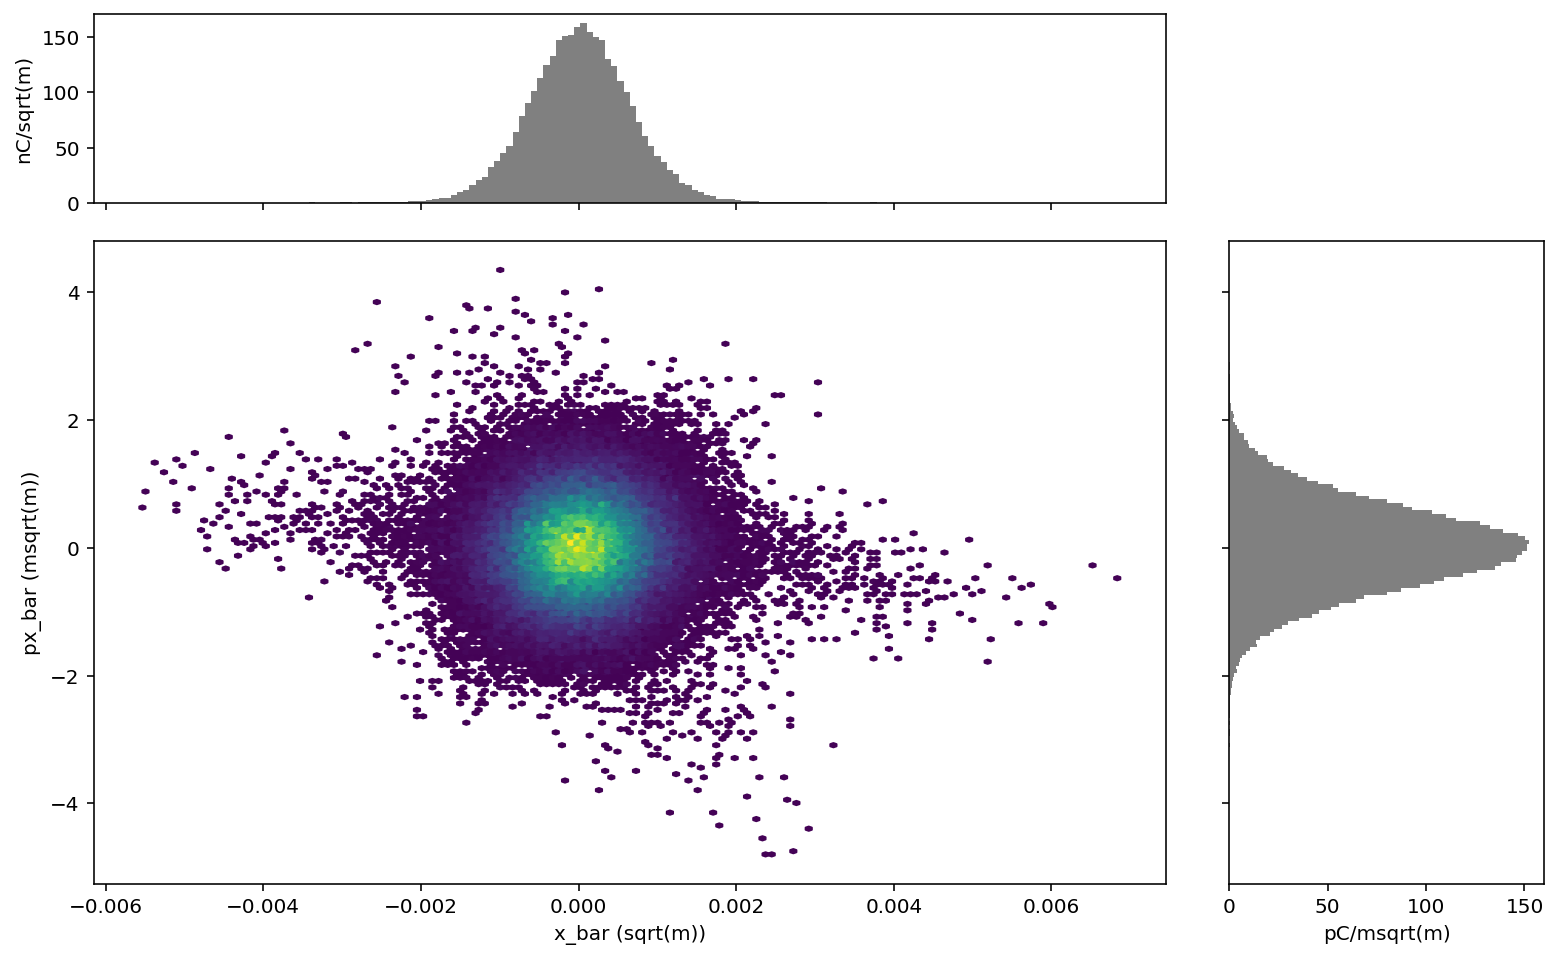

In [20]:
# This is now nice and roundish
P.plot('x_bar', 'px_bar')

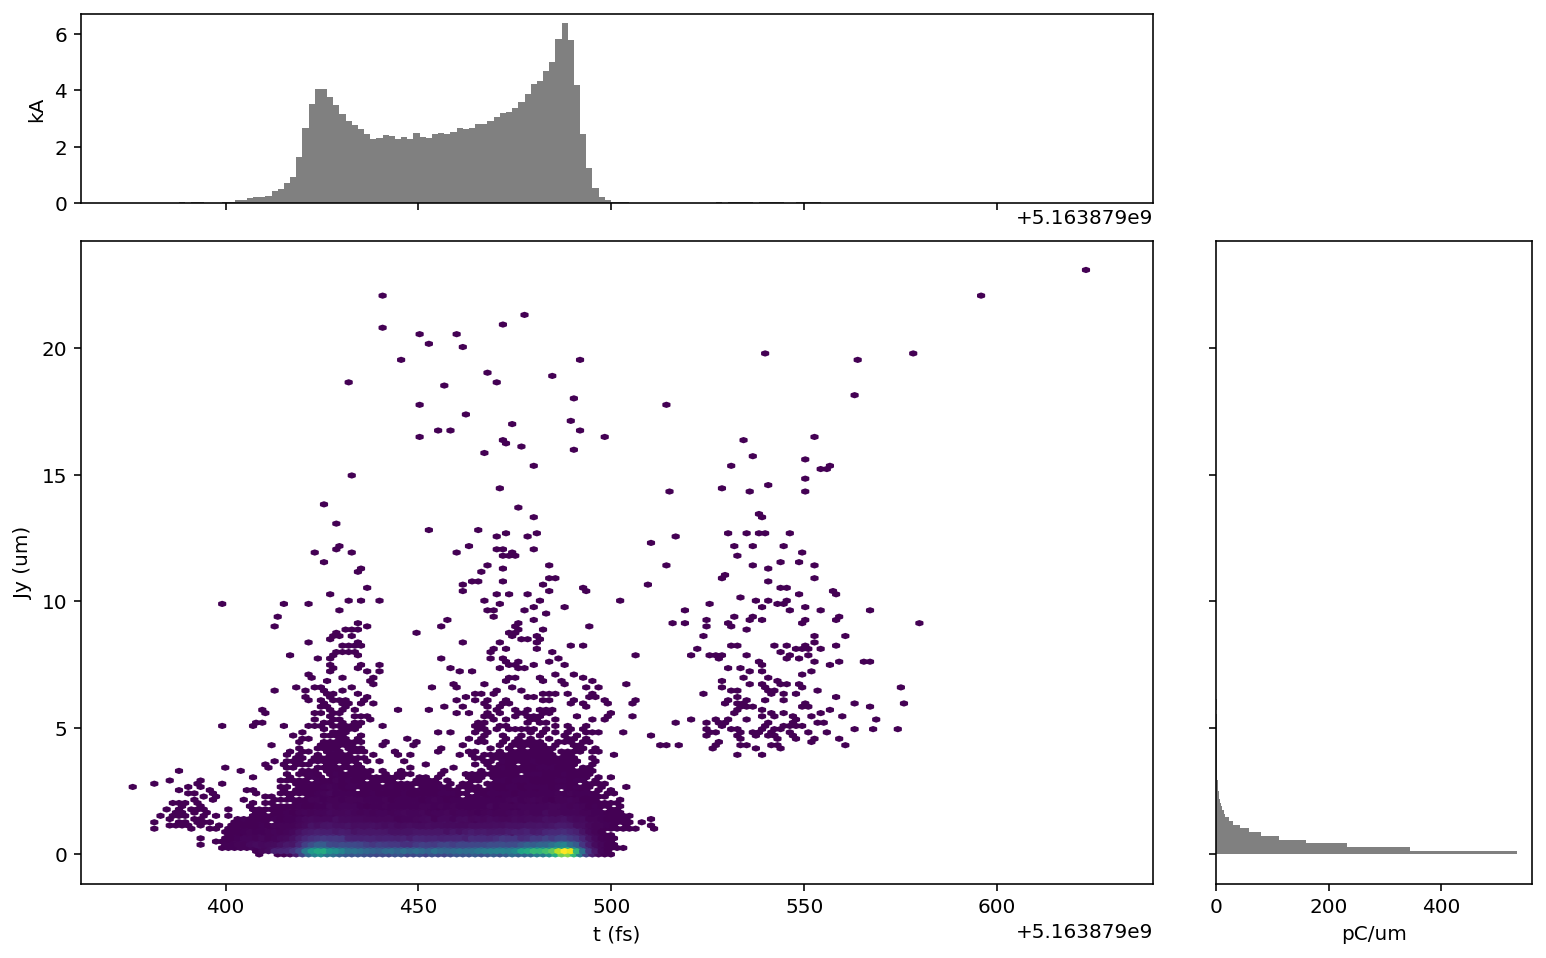

In [21]:
# Jy also works. This gives some sense of where the emittance is larger. 
P.plot('t', 'Jy')

In [22]:
# Sort by Jx:
P = P[np.argsort(P.Jx)]

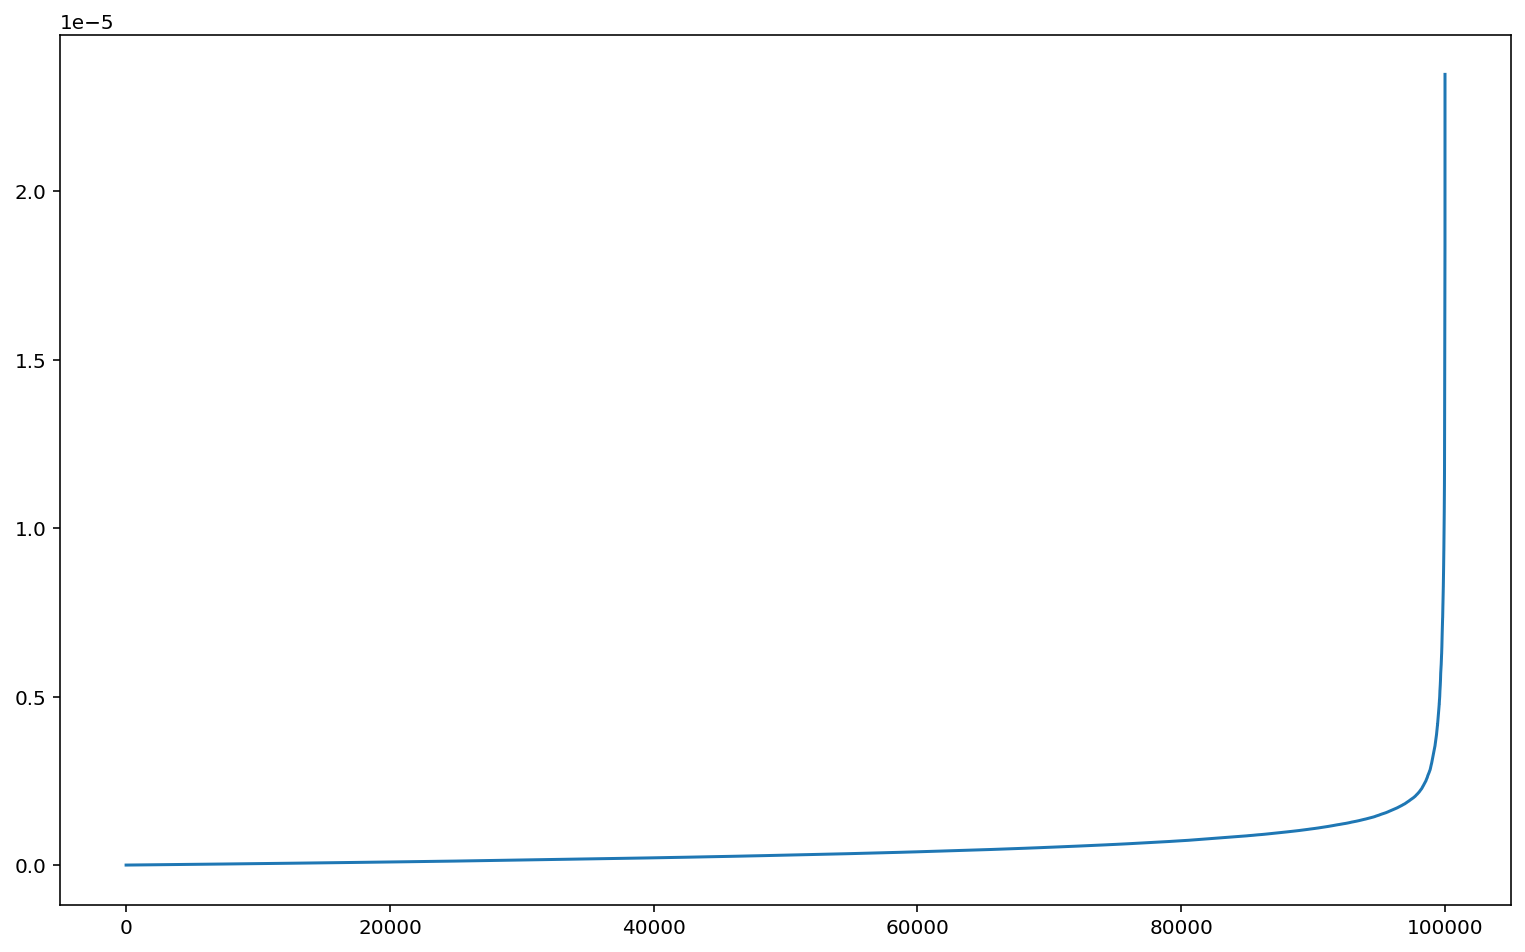

In [23]:
# Now particles are ordered
plt.plot(P.Jx)

In [24]:
# This can be used to calculate the 95% emittance
P[0:int(0.95*len(P))]['norm_emit_x']

3.739994015844235e-07